# Train and Optimize

Train a neural network on PANCAN+GTEX gene expression to classify primary site and tumor/normal

Optimize the model using [Hyperband](http://fastml.com/tuning-hyperparams-fast-with-hyperband/) after a subset of genes are identified based on the top Shapely values to determine of the same tumor/normal and disease classification can be achieved.

In [16]:
import sys
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf

np.random.seed(42)  # reproducibility

print("GPU Available:", tf.test.is_gpu_available())

# Simple syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") == "True" else no_debug_param
print(debug("DEBUG: ON", "DEBUG: OFF"))

GPU Available: False
DEBUG: ON


In [35]:
# Connect to S3 via boto3 so we can read and write
import boto3

bucket_name = "stuartlab"

session = boto3.session.Session(profile_name=os.getenv("AWS_PROFILE"))
bucket = session.resource(
    "s3", endpoint_url=os.getenv("AWS_S3_ENDPOINT")).Bucket(bucket_name)
print("S3 Profile: {} Endpoint: {} Bucket: {}".format(
    os.getenv("AWS_PROFILE"), os.getenv("AWS_S3_ENDPOINT"), bucket_name))

S3 Profile: prp Endpoint: https://s3.nautilus.optiputer.net Bucket: stuartlab


## Load and Wrangle Data

In [38]:
if not os.path.exists("pancan-gtex.h5"):
    print("Downloading dataset...")
    bucket.download_file("pancan-gtex/pancan-gtex.h5", "pancan-gtex.h5")
    
print("Loading dataset...")
X = pd.read_hdf("pancan-gtex.h5", "samples")
Y = pd.read_hdf("pancan-gtex.h5", "labels")
print("Loaded {} samples with {} features and {} labels".format(X.shape[0], X.shape[1], Y.shape[1]))

Loading dataset...
Loaded 17964 samples with 6974 features and 40 labels


In [39]:
# Create a multi-label one-hot for tumor/normal and primary site
from sklearn.preprocessing import LabelEncoder

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(
    primary_site_encoder.fit_transform(Y["_primary_site"]), index=Y.index, dtype='int32')

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(
    tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index, dtype='int32')

Y_onehot = np.append(
    Y["tumor_normal_value"].values.reshape(Y.shape[0],-1), 
    tf.keras.utils.to_categorical(Y["primary_site_value"]), axis=1)

In [40]:
# Split into training and test sets strattified on primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X.values, Y.primary_site_value):
    X_train = X.values[train_index]
    X_test = X.values[test_index]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
    Y_onehot_train = Y_onehot[train_index]
    Y_onehot_test = Y_onehot[test_index]
    
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (14371, 6974) Test: (3593, 6974)


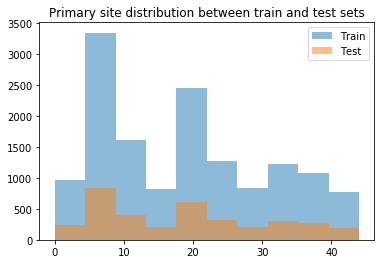

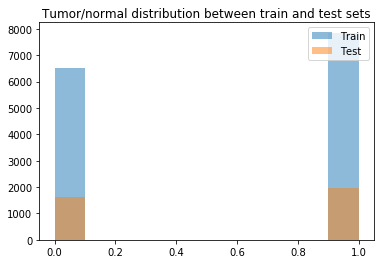

In [41]:
import matplotlib.pyplot as plt

# Lets see how big each class is based on primary site
plt.hist(Y_train.primary_site_value.values, alpha=0.5, label='Train')
plt.hist(Y_test.primary_site_value.values, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Primary site distribution between train and test sets")
plt.show()

# Lets see how big each class is based tumor/normal
plt.hist(Y_train.tumor_normal_value.values, alpha=0.5, label='Train')
plt.hist(Y_test.tumor_normal_value.values, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Tumor/normal distribution between train and test sets")
plt.show()

In [42]:
# From https://github.com/mbernico/deep_learning_quick_reference/blob/master/chapter_6/mnist_hyperband_search.py
import numpy as np
import random
from math import log, ceil
from time import time, ctime

class Hyperband:
    def __init__(self, data, get_params_function, try_params_function, max_iter=81):
        self.data = data
        self.get_params = get_params_function
        self.try_params = try_params_function

        self.max_iter = max_iter  # maximum iterations per configuration
        self.eta = 3  # defines configuration downsampling rate (default = 3)

        self.logeta = lambda x: log(x) / log(self.eta)
        self.s_max = int(self.logeta(self.max_iter))
        self.B = (self.s_max + 1) * self.max_iter

        self.results = []  # list of dicts
        self.counter = 0
        self.best_loss = np.inf
        self.best_counter = -1

    # can be called multiple times
    def run(self, skip_last=0):

        for s in list(reversed(range(self.s_max + 1)))[:1 if os.environ.get("DEBUG") else -1]:

            # initial number of configurations
            n = int(ceil(self.B / self.max_iter / (s + 1) * self.eta ** s))

            # initial number of iterations per config
            r = self.max_iter * self.eta ** (-s)

            # n random configurations
            T = [self.get_params() for i in range(n)]

            for i in list(range((s + 1) - int(skip_last)))[:1 if os.environ.get("DEBUG") else -1]:  # changed from s + 1

                # Run each of the n configs for <iterations>
                # and keep best (n_configs / eta) configurations

                n_configs = n * self.eta ** (-i)
                n_iterations = r * self.eta ** (i)

                print("\n*** {} configurations x {:.1f} iterations each".format(
                    n_configs, n_iterations))

                val_losses = []
                early_stops = []

                for t in T[:1 if os.environ.get("DEBUG") else -1]:

                    self.counter += 1
                    print("\n{} | {} | lowest loss so far: {:.4f} (run {})\n".format(
                        self.counter, ctime(), self.best_loss, self.best_counter))

                    start_time = time()

                    result = self.try_params(self.data, n_iterations, t)

                    assert (type(result) == dict)
                    assert ('loss' in result)

                    seconds = int(round(time() - start_time))
                    print("\n{} seconds.".format(seconds))

                    loss = result['loss']
                    val_losses.append(loss)

                    early_stop = result.get('early_stop', False)
                    early_stops.append(early_stop)

                    # keeping track of the best result so far (for display only)
                    # could do it be checking results each time, but hey
                    if loss < self.best_loss:
                        self.best_loss = loss
                        self.best_counter = self.counter

                    result['counter'] = self.counter
                    result['seconds'] = seconds
                    result['params'] = t
                    result['iterations'] = n_iterations
                    result['num_model_params'] = result['model'].count_params()
                    del result['model']

                    self.results.append(result)

                # select a number of best configurations for the next loop
                # filter out early stops, if any
                indices = np.argsort(val_losses)
                T = [T[i] for i in indices if not early_stops[i]]
                T = T[0:int(n_configs / self.eta)]

        return self.results

## Build and Train Model

In [43]:
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

def load_data():
    return {
        "train_X": X_train, "train_y": Y_onehot_train,
        "val_X": X_train, "val_y": Y_onehot_train, 
        "test_X": X_test, "test_y": Y_onehot_test}

def create_model(input_shape, output_shape, hyperparameters={"width": 64, "penalty": 1e-5}):
    inputs = Input(shape=(input_shape,))

    x = BatchNormalization()(inputs)
        
    for i in range(hyperparameters["depth"]):
        x = Dense(hyperparameters["width"], activity_regularizer=regularizers.l1(hyperparameters["penalty"]), activation="relu")(x)
        x = Dropout(0.5)(x)

    outputs = Dense(output_shape, activation="sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam")

    return model

def get_hyperparameters():
    return {
        "batch_size": random.choice([64]),
        "depth": random.choice([2, 3, 5]),
        "width": random.choice([32, 64]),
        "penalty": random.choice([0.01, 0.05])
    }

def try_params(data, num_iters, hyperparameters):
    model = create_model(X_train.shape[1], Y_onehot_train.shape[1], hyperparameters)
    if os.environ.get("DEBUG"):
        model.summary()
    model.fit(x=data["train_X"], y=data["train_y"],
              batch_size=hyperparameters["batch_size"],
              epochs=int(num_iters))
    loss = model.evaluate(x=data["val_X"], y=data["val_y"], verbose=0)
    return {"loss": loss, "model": model}


data = load_data()
hyperband = Hyperband(data, get_hyperparameters, try_params)
results = hyperband.run()

print("Completed training.")

print("Top hyperparameter combinations:")
print(sorted(results, key=lambda r: r["loss"])[0])


*** 81 configurations x 1.0 iterations each

1 | Fri Nov 23 22:52:39 2018 | lowest loss so far: inf (run -1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 6974)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6974)              27896     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                223200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_______________________________

In [44]:
with open("params.json", "w") as f:
    f.write(json.dumps({
        "hyperparameters": results,
        "tumor_normal": tumor_normal_encoder.classes_.tolist(),
        "primary_site": primary_site_encoder.classes_.tolist(),
        "train_indices": train_index.tolist(),
        "test_indices": test_index.tolist()}))
    
# model.save(model.fh5)